# This notebook shows how to deconvolve example (low resolution) PAX data

The data was originally described by G. L. Dakovski et al. (2017) and analyzed with different means

In [1]:
%matplotlib auto
import numpy as np 
import matplotlib.pyplot as plt 

import pax_lcls2016
from pax_deconvolve.deconvolution import deconvolvers

Using matplotlib backend: MacOSX


In [2]:
specs = pax_lcls2016.get_lcls_specs()

Text(0, 0.5, 'Intensity (a.u.)')

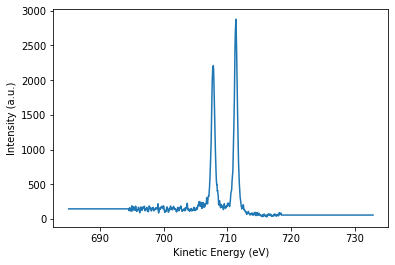

In [3]:
# Plot the measured Au 4f photoemission spectrum
plt.figure()
plt.plot(specs['psf']['x'], specs['psf']['y'])
plt.gca().set_xlabel('Kinetic Energy (eV)')
plt.gca().set_ylabel('Intensity (a.u.)')

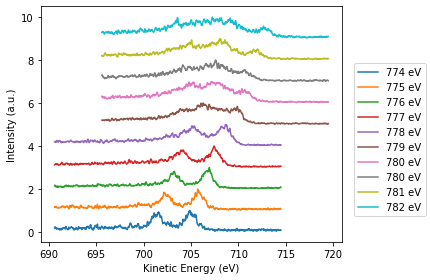

In [4]:
# Now plot the measured PAX spectra
plt.figure()
for ind, spec in enumerate(specs['spectra']):
    norm_spec = spec['y']/np.amax(spec['y'])
    offset = ind
    incident_photon_energy = specs['incident_photon_energy'][ind]
    label = ''.join([str(incident_photon_energy), ' eV'])
    plt.plot(spec['x'], norm_spec+offset, label=label)
plt.gcf().legend(loc=7)
plt.gca().set_xlabel('Kinetic Energy (eV)')
plt.gca().set_ylabel('Intensity (a.u.)')
plt.gcf().tight_layout()
plt.gcf().subplots_adjust(right=0.8)

In [5]:
# Estimate best regularization strength from data
deconvolver = deconvolvers.LRFisterGrid(
    specs['psf']['x'],
    specs['psf']['y']/np.sum(specs['psf']['y']),
    specs['spectra'][ind]['x'],
    cv_folds=2,
)
to_fit = np.array([specs['spectra'][6]['y'], specs['spectra'][7]['y']])
_ = deconvolver.fit(to_fit)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   13.4s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   13.5s finished


Automatic pdb calling has been turned ON
0.1


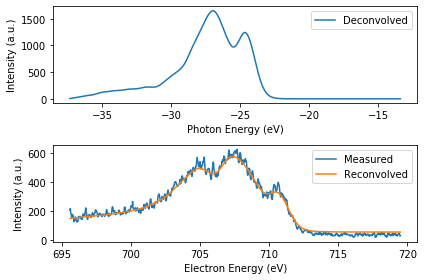

In [6]:
from pax_deconvolve import visualize
visualize.plot_result(deconvolver)
#visualize.plot_cv(deconvolver)
print(deconvolver.best_regularization_strength_)

In [7]:
# Deconvolve the PAX spectra
deconvolver_list = []
for ind, spec in enumerate(specs['spectra']):
    deconvolver = deconvolvers.LRFisterDeconvolve(
        specs['psf']['x'],
        specs['psf']['y']/np.sum(specs['psf']['y']),
        specs['spectra'][ind]['x'],
        regularization_strength=0.1,
        iterations=1000
    )
    test0 = spec['y']
    test = np.array([test0])
    _ = deconvolver.fit(test)
    deconvolver_list.append(deconvolver)

In [8]:
def init_paper_small():
    # Same as init_paper, but with small lines
    plt.rcParams['figure.figsize'] = (3.37, 4)
    plt.rcParams['font.size'] = 8
    #plt.rcParams['font.family'] = 'Times'
    plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']*1
    plt.rcParams['axes.titlesize'] = plt.rcParams['font.size']*1
    plt.rcParams['legend.fontsize'] = plt.rcParams['font.size']
    plt.rcParams['xtick.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['ytick.labelsize'] = plt.rcParams['font.size']
    #plt.rcParams['savefig.dpi'] = 2*plt.rcParams['savefig.dpi']
    plt.rcParams['xtick.major.size'] = 3
    plt.rcParams['xtick.minor.size'] = 3
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['xtick.minor.width'] = 1
    plt.rcParams['ytick.major.size'] = 3
    plt.rcParams['ytick.minor.size'] = 3
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['ytick.minor.width'] = 1
    plt.rcParams['legend.frameon'] = False
    plt.rcParams['legend.loc'] = 'center left'
    plt.rcParams['axes.linewidth'] = 0.5
    plt.rcParams['lines.linewidth'] = 1.25
    plt.rcParams['legend.numpoints'] = 1
    plt.rcParams['legend.scatterpoints'] = 1
    plt.rcParams['legend.handlelength'] = 1
    plt.rcParams['legend.borderpad'] = 0.3
    plt.rcParams['legend.borderaxespad'] = 0.3
    
init_paper_small()

In [9]:
%pdb
%matplotlib qt

photon_energy_offset = 804.23    # determined empirically
# Make figure showing deconvolved results
f, axs = plt.subplots(1, 2, sharey=True, figsize=(3.37*2.0, 3.75))
for ind, deconvolved_spec in enumerate(deconvolver_list):
    incident_photon_energy = specs['incident_photon_energy'][ind]
    label = ''.join([str(incident_photon_energy), ' eV'])
    norm = np.amax(deconvolver_list[ind].measured_y_)
    axs[0].plot(deconvolver_list[ind].convolved_x, -1.1*ind+deconvolver_list[ind].measured_y_/norm, 'k--')
    axs[0].plot(deconvolver_list[ind].convolved_x, -1.1*ind+deconvolver_list[ind].reconstruction_y_/norm, label=label)
    norm = np.amax(deconvolver_list[ind].deconvolved_y_)
    energy_loss = -1*(deconvolver_list[ind].deconvolved_x-specs['incident_photon_energy'][ind]+photon_energy_offset)
    axs[1].plot(energy_loss, -1.1*ind+deconvolver_list[ind].deconvolved_y_/norm)
#axs[0].set_title('PAX ')
#axs[1].set_title('Deconvolved')

plt.gcf().legend(loc='right', title='Incident Photon\nEnergy (eV)', frameon=True)
#plt.gca().set_xlabel('Kinetic Energy (eV)')
axs[0].set_ylabel('Intensity (a.u.)')
axs[0].set_xlabel('Kinetic Energy (eV)')
axs[1].set_xlabel('Energy Loss (eV)')
axs[0].text(0.9, 0.95, 'A', fontsize=10, weight='bold', horizontalalignment='center',
                   transform=axs[0].transAxes)
axs[0].text(0.5, 0.95, 'PAX', fontsize=10, horizontalalignment='center',
                   transform=axs[0].transAxes)
axs[1].text(0.1, 0.95, 'B', fontsize=10, weight='bold', horizontalalignment='center',
       transform=axs[1].transAxes)
axs[1].text(0.5, 0.95, 'RIXS', fontsize=10, horizontalalignment='center',
                   transform=axs[1].transAxes)
axs[0].set_xlim((690, 720))
axs[0].set_ylim((-10, 2))
axs[1].set_xlim((-5, 15))
axs[1].invert_xaxis()
plt.gcf().tight_layout()
plt.gcf().subplots_adjust(right=0.8)

Automatic pdb calling has been turned OFF
